In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [3]:
DATASET_PATH = "/content/drive/MyDrive/SafeReels-664/Frames"
IMG_SIZE = (224, 224)
NUM_CLASSES = 4

In [4]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [5]:
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs, x)

In [6]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [7]:
def load_video_frames(video_folder):
    frames = []
    frame_files = sorted(os.listdir(video_folder))
    for file in frame_files:
        img_path = os.path.join(video_folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        img = preprocess_input(img)
        frames.append(img)

    return np.array(frames)

In [8]:
X, y = [], []

In [9]:
import pandas as pd
df = pd.read_csv("/content/Safereels annotation - Text_Annotation_data.csv")
df

,reel_id,isSafe,UnsafeType,Visual texts,Audio texts
0,www.facebook.com/reel/1000188341415358,1,Safe,Me on my way to watch Oppenheimer After Berbie,NaN
1,www.facebook.com/reel/1006146964533997,1,Safe,NaN,এ মামা দুইটা সিঙ্গারা আর দুইটা সমুচা একটু তাড়া...
2,www.facebook.com/reel/1007123741459823,0,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love,পাগলা হাওয়ার বাদল দিনে পাগল আমার মন জেগে ওঠে প...
3,www.facebook.com/reel/1007420607202244,1,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop,যুদ্ধ আনে ধ্বংস সজনী সজনী তোমারে দেখিয়া মাতাল ...
4,www.facebook.com/reel/1008519870870927,1,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং,NaN
...,...,...,...,...,...
659,www.facebook.com/reel/997262608752854,0,Adult,NaN,NaN
660,www.facebook.com/reel/997300345735398,0,Harmful,NaN,NaN
661,www.facebook.com/reel/998187401354206,1,Safe,খবরঃ কয়লা নিয়ে মোংলা বন্দরে এলো চীনের জাহাজ দে...,NaN
662,www.facebook.com/reel/999558344609179,1,Safe,সাকিব আল হাসান to বাংলাদেশী ক্রিকেট ফ্যান,NaN


In [10]:
df['UnsafeType'], uniques = pd.factorize(df['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [11]:
for _, row in df.iterrows():
    reel_id = row["reel_id"].strip("www.facebook.com/reel/")
    video_folder = os.path.join(DATASET_PATH, reel_id)
    label = row["UnsafeType"]

    if os.path.isdir(video_folder):
        frames = load_video_frames(video_folder)
        X.append(frames)
        y.append(label)

In [12]:
X = np.array(X)
y = np.array(y)

In [13]:
X.shape

(664, 5, 224, 224, 3)

In [14]:
y.shape

(664,)

In [15]:
X = X.reshape(-1, 224, 224, 3)
y = np.repeat(y, 5)

In [16]:
X.shape

(3320, 224, 224, 3)

In [17]:
y.shape

(3320,)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
model.fit(X_train, y_train, batch_size=8, epochs=10, validation_split=0.1)

Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.6208 - loss: 1.2765 - val_accuracy: 0.7105 - val_loss: 0.8272
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.7613 - loss: 0.5907 - val_accuracy: 0.7368 - val_loss: 0.6440
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8416 - loss: 0.4122 - val_accuracy: 0.7669 - val_loss: 0.5930
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8993 - loss: 0.2837 - val_accuracy: 0.7180 - val_loss: 0.8189
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9314 - loss: 0.1997 - val_accuracy: 0.8271 - val_loss: 0.5361
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9452 - loss: 0.1651 - val_accuracy: 0.8421 - val_loss: 0.4554
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9726 - loss: 0.0834 - val_accuracy: 0.8571 - val_loss: 0.4575
Epoch 8/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9795 - loss: 0.0659 - 

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 399ms/step


In [22]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       416
           1       0.85      0.87      0.86       179
           2       0.88      0.79      0.83        66
           3       1.00      1.00      1.00         3

    accuracy                           0.90       664
   macro avg       0.91      0.90      0.90       664
weighted avg       0.90      0.90      0.90       664



In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

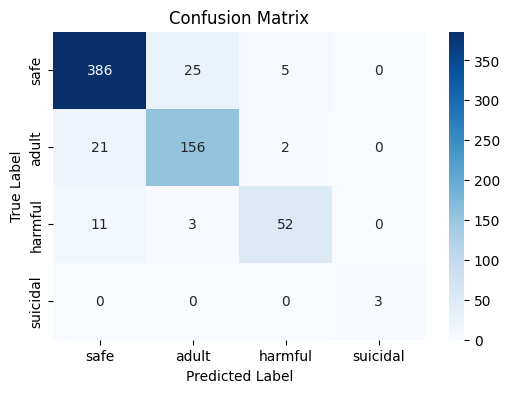

In [24]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["safe","adult","harmful","suicidal"], yticklabels=["safe","adult","harmful","suicidal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()